In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [2]:
#Define the number of elements in each set I, J, K
i_num = 14
k_num = 5
j_num = 500 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])


In [3]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 25000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 25000), 0)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 25000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 25000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 25000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 25000), 0)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,2444.0,2264.0
j1,j1,21272.0,7069.0
j2,j2,21447.0,7084.0
j3,j3,6721.0,12135.0
j4,j4,22449.0,13115.0
...,...,...,...
i9,i9,4238.0,20798.0
i10,i10,10679.0,19681.0
i11,i11,14847.0,8085.0


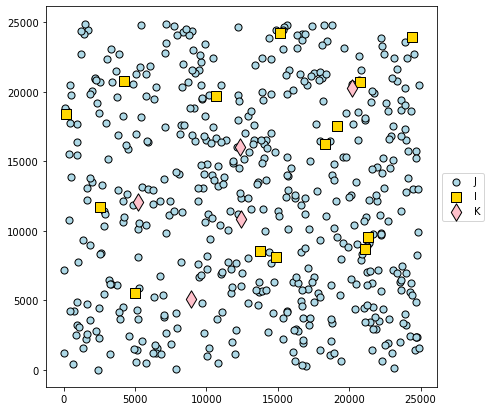

In [4]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
#Define constants

B = 17 * (90 * 60) #battery load: meters of travel
S = 17 * (10 * 60) #meters of service time
alpha = 14760 + 500 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400000
    else:
        beta[j] = 300000
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {j: 50 for j in J.index}

up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 11,
 'i1': 9,
 'i2': 4,
 'i3': 2,
 'i4': 6,
 'i5': 10,
 'i6': 5,
 'i7': 2,
 'i8': 10,
 'i9': 10,
 'i10': 5,
 'i11': 0,
 'i12': 8,
 'i13': 11}

Deterministic model

In [6]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 16,
 'i1': 5,
 'i2': 3,
 'i3': 3,
 'i4': 5,
 'i5': 11,
 'i6': 7,
 'i7': 0,
 'i8': 7,
 'i9': 12,
 'i10': 4,
 'i11': 0,
 'i12': 3,
 'i13': 12}

In [7]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 25265.457882254974,
 ('k0', 'j1'): 13220.106542687165,
 ('k0', 'j2'): 13220.60652920281,
 ('k0', 'j3'): 15724.722064316431,
 ('k0', 'j4'): 7478.397956781921,
 ('k0', 'j5'): 11647.927927318231,
 ('k0', 'j6'): 22866.708114636876,
 ('k0', 'j7'): 18888.60357464257,
 ('k0', 'j8'): 18460.498205628148,
 ('k0', 'j9'): 15711.698125918789,
 ('k0', 'j10'): 18244.291710011654,
 ('k0', 'j11'): 20730.256968981354,
 ('k0', 'j12'): 15998.440236473054,
 ('k0', 'j13'): 19204.395460414784,
 ('k0', 'j14'): 11125.407722865712,
 ('k0', 'j15'): 5973.886590821758,
 ('k0', 'j16'): 7179.41738583292,
 ('k0', 'j17'): 20400.56923225428,
 ('k0', 'j18'): 16672.3299511496,
 ('k0', 'j19'): 6451.664591405849,
 ('k0', 'j20'): 9901.279563773563,
 ('k0', 'j21'): 16948.538373558942,
 ('k0', 'j22'): 14518.163244708334,
 ('k0', 'j23'): 25698.04741609759,
 ('k0', 'j24'): 5288.864244807197,
 ('k0', 'j25'): 5272.856626156262,
 ('k0', 'j26'): 18974.89736467631,
 ('k0', 'j27'): 19266.572217184872,
 ('k0', 'j28'): 1

In [8]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [9]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [10]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())
N_i

{'i0': [('k0', 'j1'),
  ('k0', 'j2'),
  ('k0', 'j4'),
  ('k0', 'j7'),
  ('k0', 'j8'),
  ('k0', 'j9'),
  ('k0', 'j10'),
  ('k0', 'j12'),
  ('k0', 'j14'),
  ('k0', 'j15'),
  ('k0', 'j16'),
  ('k0', 'j20'),
  ('k0', 'j21'),
  ('k0', 'j22'),
  ('k0', 'j27'),
  ('k0', 'j29'),
  ('k0', 'j30'),
  ('k0', 'j31'),
  ('k0', 'j32'),
  ('k0', 'j33'),
  ('k0', 'j35'),
  ('k0', 'j36'),
  ('k0', 'j39'),
  ('k0', 'j41'),
  ('k0', 'j46'),
  ('k0', 'j47'),
  ('k0', 'j49'),
  ('k0', 'j52'),
  ('k0', 'j61'),
  ('k0', 'j65'),
  ('k0', 'j68'),
  ('k0', 'j71'),
  ('k0', 'j73'),
  ('k0', 'j76'),
  ('k0', 'j77'),
  ('k0', 'j78'),
  ('k0', 'j79'),
  ('k0', 'j80'),
  ('k0', 'j88'),
  ('k0', 'j92'),
  ('k0', 'j94'),
  ('k0', 'j95'),
  ('k0', 'j96'),
  ('k0', 'j97'),
  ('k0', 'j98'),
  ('k0', 'j99'),
  ('k0', 'j100'),
  ('k0', 'j101'),
  ('k0', 'j102'),
  ('k0', 'j107'),
  ('k0', 'j110'),
  ('k0', 'j112'),
  ('k0', 'j113'),
  ('k0', 'j117'),
  ('k0', 'j125'),
  ('k0', 'j130'),
  ('k0', 'j131'),
  ('k0', 'j137'),
  

In [11]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [12]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj_final[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i_final[i] for i in M_kj_final[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i_final[i] for i in M_kj_final[(k, j)]), name = 'c6')

{('k0', 'j19', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j19', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j19', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j19', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j19', 'i12'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j19', 'i13'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j24', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j24', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j24', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j24', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j24', 'i12'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j24', 'i13'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j25', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j25', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j25', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j25', 'i10'): <gurobi.Constr *Awaiting M

In [13]:
model_det.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i_final[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8229 rows, 36849 columns and 34420 nonzeros
Model fingerprint: 0xa416614b
Variable types: 0 continuous, 36849 integer (519 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 9e+04]
Found heuristic solution: objective 4483131.0109
Presolve removed 5682 rows and 25366 columns
Presolve time: 0.06s
Presolved: 2547 rows, 11483 columns, 24486 nonzeros
Found heuristic solution: objective 1683131.0109
Variable types: 0 continuous, 11483 integer (508 binary)

Root relaxation: objective 2.887205e+05, 1187 iterations, 0.08 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

In [14]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 4
0
1.12891e+06 
x_ikj[i0,k2,i4] 50
x_ikj[i0,k3,i4] 50
x_ikj[i0,k4,i4] 45
x_ikj[i1,k0,k3] 38
x_ikj[i2,k4,k3] 3
x_ikj[i3,k0,i4] 50
x_ikj[i4,k4,i4] 5
x_ikj[i5,k1,i4] 50
x_ikj[i6,k1,k3] 50
x_ikj[i6,k2,k3] 50
x_ikj[i6,k3,k3] 50
x_ikj[i8,k4,k3] 43
x_ikj[i9,k0,k3] 12
x_ikj[i10,k4,k3] 4
x_ikj[i12,k0,i3] 3
x_ikj[i13,k4,i3] 12
y_j[k3] 1
y_j[i3] 1
y_j[i4] 1


1
1.12891e+06 
x_ikj[i0,k2,i4] 50
x_ikj[i0,k3,i4] 50
x_ikj[i0,k4,i4] 45
x_ikj[i1,k0,k3] 38
x_ikj[i2,k4,k3] 3
x_ikj[i3,k0,i4] 50
x_ikj[i4,k4,i4] 5
x_ikj[i5,k1,i4] 50
x_ikj[i6,k1,k3] 50
x_ikj[i6,k2,k3] 50
x_ikj[i6,k3,k3] 50
x_ikj[i8,k4,k3] 43
x_ikj[i9,k0,k3] 12
x_ikj[i10,k4,k3] 4
x_ikj[i12,k0,i3] 3
x_ikj[i13,k4,i3] 12
y_j[k3] 1
y_j[i3] 1
y_j[i4] 1


2
1.68313e+06 
x_ikj[i0,k2,i4] 50
x_ikj[i0,k3,i4] 50
x_ikj[i0,k4,i4] 45
x_ikj[i1,k0,k3] 38
x_ikj[i2,k4,k3] 3
x_ikj[i3,k0,i4] 50
x_ikj[i4,k4,i4] 5
x_ikj[i5,k1,i4] 50
x_ikj[i6,k1,k3] 50
x_ikj[i6,k2,k3] 50
x_ikj[i6,k3,k3] 50
x_ikj[i8,k4,k3] 43
x_ikj[i9,k0,k3] 12
x_ikj[i10,k

In [15]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations

SolutionSummary(model_det)

(      i  Number of drones
 0    i0               145
 1    i1                38
 2   i10                 4
 3   i12                 3
 4   i13                12
 5    i2                 3
 6    i3                50
 7    i4                 5
 8    i5                50
 9    i6               150
 10   i8                43
 11   i9                12,
     j  Number of drones
 0  i3                15
 1  i4               250
 2  k3               250)

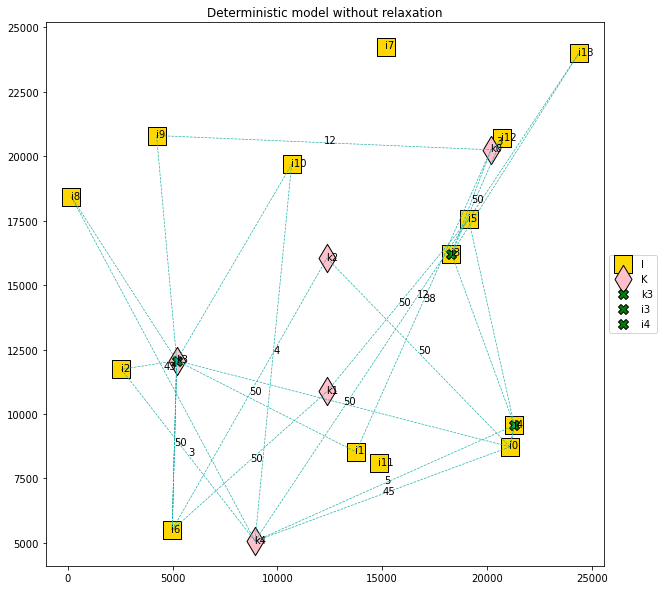

In [17]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (10, 10))
                
        fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Latitude'][i] - 40, I['Longitude'][i] - 60))
                
        fig.scatter(K['Latitude'], K['Longitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Latitude'][k] - 40, K['Longitude'][k] - 60))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                 (K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                                # fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                #                                 (J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)